# EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from  nltk import FreqDist

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from mlxtend.feature_selection import ColumnSelector
from sklearn.feature_selection import chi2

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

from sklearn.model_selection import train_test_split
import re
import string

In [2]:
df = pd.read_pickle("../data/df.pkl")
df.head()

,Publication,Content,Bias
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left
1,CNN,Atlanta (CNN) This season’s College Football P...,Left
2,CNN,(CNN) Revelers on the United States’ west coa...,Left
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left
4,CNN,(CNN) Two small planes collided in Texas on S...,Left


In [3]:
df.shape

(85365, 3)

In [4]:
df.info

<bound method DataFrame.info of            Publication                                            Content  \
0                  CNN  Istanbul (CNN) At least 39 people were killed ...   
1                  CNN  Atlanta (CNN) This season’s College Football P...   
2                  CNN   (CNN) Revelers on the United States’ west coa...   
3                  CNN  West Palm Beach, Florida (CNN)  Donald Trump s...   
4                  CNN   (CNN) Two small planes collided in Texas on S...   
...                ...                                                ...   
85360  National Review  I first read Thomas Sowell in college  —   no ...   
85361  National Review  Whether it’s celebrated according to the Grego...   
85362  National Review  Editor’s Note: This piece first appeared in th...   
85363  National Review  Israel would seem to be in a disastrous positi...   
85364  National Review  The year 2016 was a good one for books by men ...   

        Bias  
0       Left  
1       Left 

In [5]:
df["Publication"].value_counts()

Breitbart          23781
The Hill           16811
Vox                16372
CNN                11488
Reuters            10710
National Review     6203
Name: Publication, dtype: int64

In [6]:
df["Bias"].value_counts()

Right     29984
Left      27860
Center    27521
Name: Bias, dtype: int64

In [7]:
print("Percentage of Articles per Bias in Dataset:")
df["Bias"].value_counts(normalize=True)*100

Percentage of Articles per Bias in Dataset:


Right     35.124466
Left      32.636326
Center    32.239208
Name: Bias, dtype: float64

In [8]:
def countplot(df, col, hue=None, rotation=None, order=None):
    """
    This function builds a Seaborn countplot and allows the user to set certain parameters to customize the graph.
    
    df - dataframe being used
    col- column in dataframe being used
    hue - second column being used(if any)
    rotation - sets the rotation of the x-ticks for readability
    """
    fig, ax = plt.subplots(figsize=(12,8))
    sns.countplot(data = df, x = col, hue = hue, order = order)
    ax.set_xticklabels(labels = ax.get_xticklabels(), rotation= rotation, fontsize = 15)
    ax.set_xlabel(xlabel = col, fontsize = 20)
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax.set_ylabel(ylabel = "Number of articles", fontsize = 20)
    ax.set_title(f"Number of articles per {col}", fontsize = 30)
    plt.show()

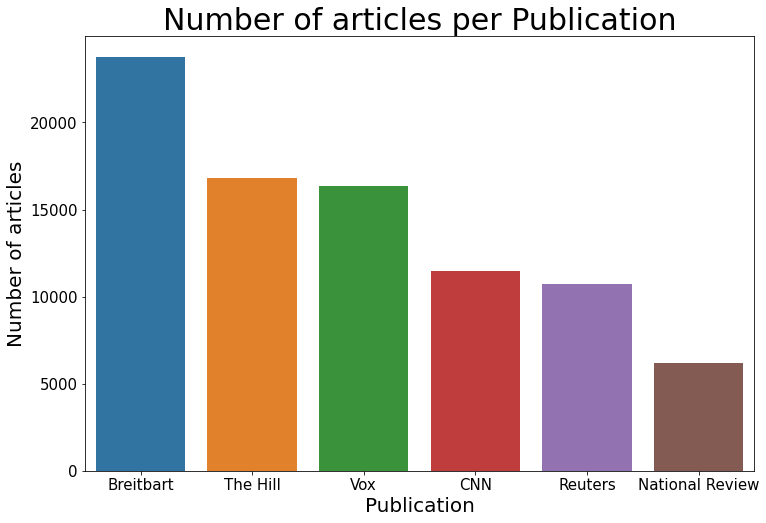

In [9]:
countplot(df, "Publication", order = df["Publication"].value_counts().index)

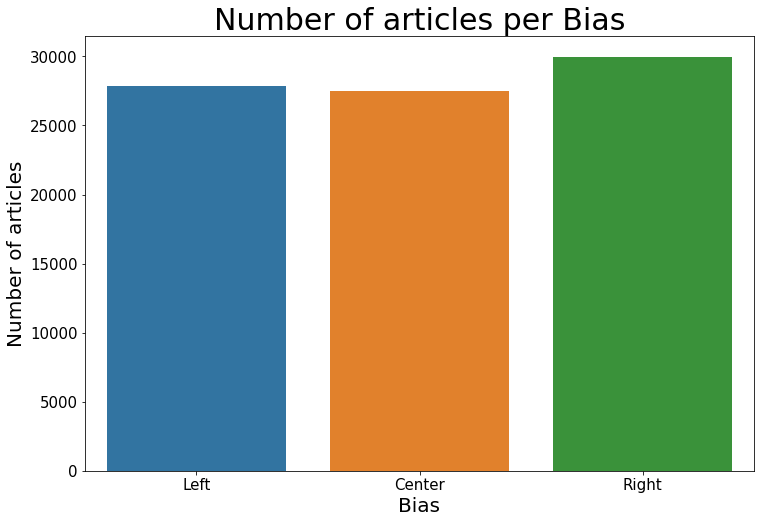

In [10]:
countplot(df, "Bias", order = ["Left", "Center", "Right"])

In [11]:
df_plot = df.groupby(['Publication', 'Bias']).size().reset_index().pivot(columns='Publication', index='Bias', values=0)

In [12]:
df_plot = df_plot.reindex(["Left", "Center", "Right"])

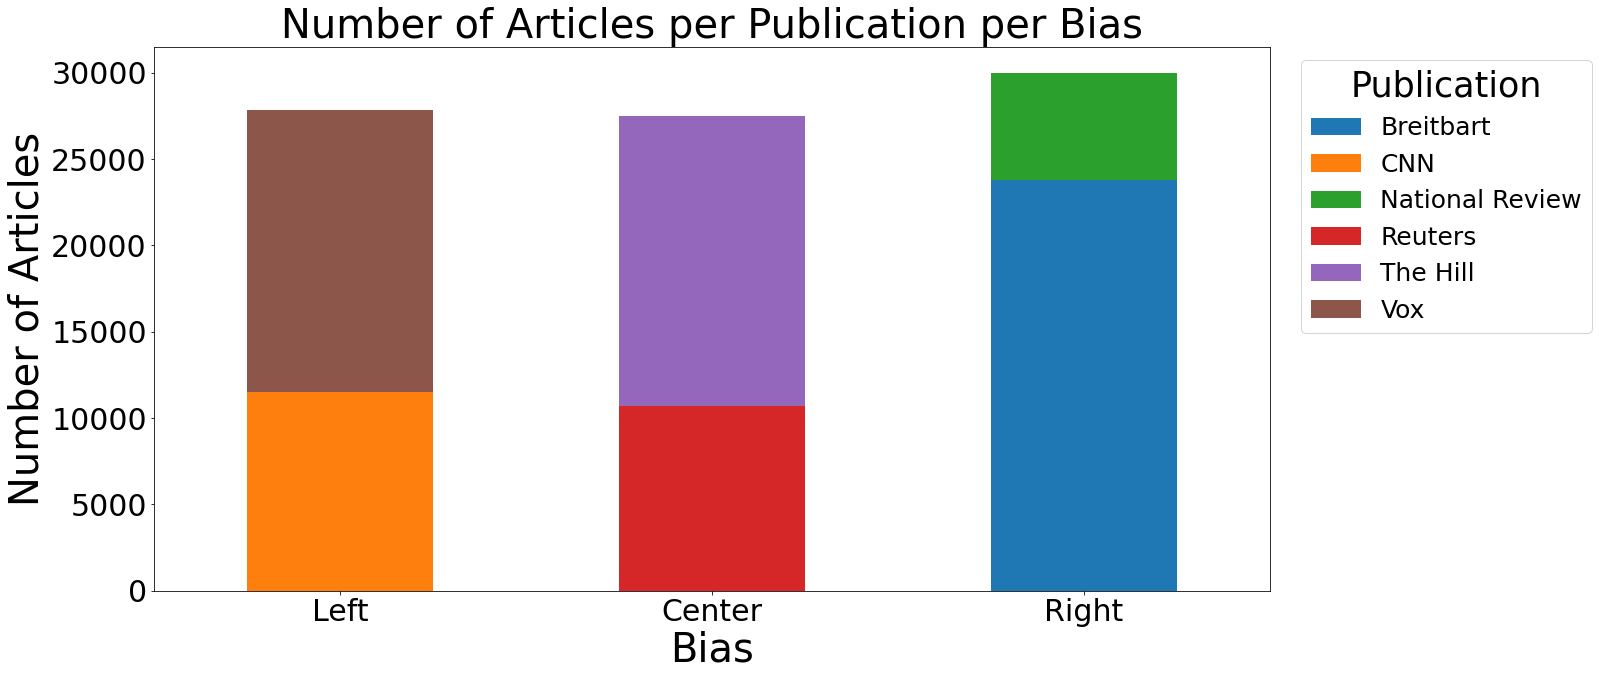

In [13]:
df_plot.plot(kind='bar', stacked=True, figsize=(20,10))
plt.xticks(rotation="horizontal", fontsize = 30)
plt.xlabel(xlabel = "Bias", fontsize = 40)
plt.yticks(rotation="horizontal", fontsize = 30)
plt.ylabel(ylabel = "Number of Articles", fontsize = 40)
plt.title(label= "Number of Articles per Publication per Bias", fontsize = 40)
plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right", ncol=1, fontsize= 25, title = "Publication", title_fontsize= 35)
plt.show()

# Preprocessing Data

In [14]:
df

,Publication,Content,Bias
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left
1,CNN,Atlanta (CNN) This season’s College Football P...,Left
2,CNN,(CNN) Revelers on the United States’ west coa...,Left
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left
4,CNN,(CNN) Two small planes collided in Texas on S...,Left
...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right
85361,National Review,Whether it’s celebrated according to the Grego...,Right
85362,National Review,Editor’s Note: This piece first appeared in th...,Right
85363,National Review,Israel would seem to be in a disastrous positi...,Right


In [15]:
#If we did a multi class
dict_sent = {'Left':-1, 
             'Center':0,
             'Right':1}
df["num_bias"] = df["Bias"].map(dict_sent)

In [16]:
df.head()

,Publication,Content,Bias,num_bias
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,-1
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,-1
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,-1
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,-1
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,-1


In [17]:
df.iloc[45000:45005]

,Publication,Content,Bias,num_bias
45000,The Hill,The Obama administration’s won’t pursue passag...,Center,0
45001,The Hill,Rep. Al GreenAlexander (Al) N. GreenWe need a ...,Center,0
45002,The Hill,View the discussion thread. The Hill 1625 K St...,Center,0
45003,The Hill,Rep. Al GreenAlexander (Al) N. GreenWe need a ...,Center,0
45004,The Hill,The public health community has been closely w...,Center,0


In [18]:
df.tail()

,Publication,Content,Bias,num_bias
85360,National Review,I first read Thomas Sowell in college — no ...,Right,1
85361,National Review,Whether it’s celebrated according to the Grego...,Right,1
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,1
85363,National Review,Israel would seem to be in a disastrous positi...,Right,1
85364,National Review,The year 2016 was a good one for books by men ...,Right,1


In [19]:
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
lemma = WordNetLemmatizer()

In [20]:
source = list(df["Publication"].unique())
source = (map(lambda x: x.lower(), source))
source = list(source)
source

['cnn', 'vox', 'reuters', 'the hill', 'breitbart', 'national review']

In [21]:
stopwords_list = stopwords.words("english")
stopwords_list += string.punctuation
stopwords_list += source
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [22]:
test = df["Content"].iloc[random.randint(0,df.shape[0])]
test

' (CNN) The Iraqi Air Force dropped millions of leaflets over western Mosul late Saturday warning residents of an offensive by ground forces on the   part of the city, which has so far been targeted only by airstrikes. Iraqi forces have had control of the eastern part of the city, which is divided by the Tigris River, since January. The leaflets say Iraqi forces are making advancements to the western side and ”provide guidance and recommendations” for citizens ahead of the offensive, according to a statement from the Iraqi Joint Operations Command (JOC). The leaflets also warn ISIS members to ”lay down their weapons and surrender before they face their inevitable fate at the hands of our heroic forces,” the statement said. As many as 800, 000 civilians live in western Mosul, according to the United Nations. It said UN humanitarian agencies in Iraq are preparing to assist civilians caught in the fighting. ”The situation is distressing,” said Lise Grande, the UN humanitarian coordinator 

In [23]:
test = test.lower()

In [24]:
pattern = "((@[a-zA-Z0-9_-]+)((?=\s+)|$|[!?.,-]))|([@][A-z]+)|([#][A-z]+)| \
                ((pic.)?twitter\.com\/[A-Za-z0-9_]{5,1000}(\?(\w+=\w+&?)*)?) | \
                ([^\x00-\x7F]+\ *(?:[^\x00-\x7F]| )*)|((view the discussion thread.)([\s\S]*)$)|\
                ((the views expressed by contributors are their own and not the views of the hill.)([\s\S]*)$)|(http\S+)|(\\d)"

In [25]:
test = re.sub(pattern,"", test)
test

' (cnn) the iraqi air force dropped millions of leaflets over western mosul late saturday warning residents of an offensive by ground forces on the   part of the city, which has so far been targeted only by airstrikes. iraqi forces have had control of the eastern part of the city, which is divided by the tigris river, since january. the leaflets say iraqi forces are making advancements to the western side and ”provide guidance and recommendations” for citizens ahead of the offensive, according to a statement from the iraqi joint operations command (joc). the leaflets also warn isis members to ”lay down their weapons and surrender before they face their inevitable fate at the hands of our heroic forces,” the statement said. as many as ,  civilians live in western mosul, according to the united nations. it said un humanitarian agencies in iraq are preparing to assist civilians caught in the fighting. ”the situation is distressing,” said lise grande, the un humanitarian coordinator for ir

In [26]:
# test = test.lower()
# test

In [27]:
test = tokenizer.tokenize(test)
test

['cnn',
 'the',
 'iraqi',
 'air',
 'force',
 'dropped',
 'millions',
 'of',
 'leaflets',
 'over',
 'western',
 'mosul',
 'late',
 'saturday',
 'warning',
 'residents',
 'of',
 'an',
 'offensive',
 'by',
 'ground',
 'forces',
 'on',
 'the',
 'part',
 'of',
 'the',
 'city',
 'which',
 'has',
 'so',
 'far',
 'been',
 'targeted',
 'only',
 'by',
 'airstrikes',
 'iraqi',
 'forces',
 'have',
 'had',
 'control',
 'of',
 'the',
 'eastern',
 'part',
 'of',
 'the',
 'city',
 'which',
 'is',
 'divided',
 'by',
 'the',
 'tigris',
 'river',
 'since',
 'january',
 'the',
 'leaflets',
 'say',
 'iraqi',
 'forces',
 'are',
 'making',
 'advancements',
 'to',
 'the',
 'western',
 'side',
 'and',
 'provide',
 'guidance',
 'and',
 'recommendations',
 'for',
 'citizens',
 'ahead',
 'of',
 'the',
 'offensive',
 'according',
 'to',
 'statement',
 'from',
 'the',
 'iraqi',
 'joint',
 'operations',
 'command',
 'joc',
 'the',
 'leaflets',
 'also',
 'warn',
 'isis',
 'members',
 'to',
 'lay',
 'down',
 'their',


In [28]:
stopwords_removed=[token for token in test if token not in stopwords_list]

In [29]:
lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
lemma_list

['iraqi',
 'air',
 'force',
 'dropped',
 'million',
 'leaflet',
 'western',
 'mosul',
 'late',
 'saturday',
 'warning',
 'resident',
 'offensive',
 'ground',
 'force',
 'part',
 'city',
 'far',
 'targeted',
 'airstrikes',
 'iraqi',
 'force',
 'control',
 'eastern',
 'part',
 'city',
 'divided',
 'tigris',
 'river',
 'since',
 'january',
 'leaflet',
 'say',
 'iraqi',
 'force',
 'making',
 'advancement',
 'western',
 'side',
 'provide',
 'guidance',
 'recommendation',
 'citizen',
 'ahead',
 'offensive',
 'according',
 'statement',
 'iraqi',
 'joint',
 'operation',
 'command',
 'joc',
 'leaflet',
 'also',
 'warn',
 'isi',
 'member',
 'lay',
 'weapon',
 'surrender',
 'face',
 'inevitable',
 'fate',
 'hand',
 'heroic',
 'force',
 'statement',
 'said',
 'many',
 'civilian',
 'live',
 'western',
 'mosul',
 'according',
 'united',
 'nation',
 'said',
 'un',
 'humanitarian',
 'agency',
 'iraq',
 'preparing',
 'assist',
 'civilian',
 'caught',
 'fighting',
 'situation',
 'distressing',
 'said',


In [30]:
freq_dist = FreqDist(lemma_list)
freq_dist

FreqDist({'iraqi': 7, 'force': 6, 'mosul': 5, 'isi': 5, 'western': 4, 'said': 4, 'leaflet': 3, 'offensive': 3, 'city': 3, 'airstrikes': 3, ...})

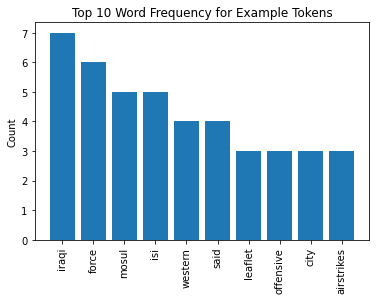

In [31]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=90)
    
visualize_top_10(freq_dist, "Top 10 Word Frequency for Example Tokens")

In [ ]:
df

In [33]:
#Instaiate needed objects
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
stopwords_list = stopwords_list
lemma = WordNetLemmatizer()

In [34]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [35]:
pattern = "((@[a-zA-Z0-9_-]+)((?=\s+)|$|[!?.,-]))|([@][A-z]+)|([#][A-z]+)| \
                ((pic.)?twitter\.com\/[A-Za-z0-9_]{5,1000}(\?(\w+=\w+&?)*)?) | \
                ([^\x00-\x7F]+\ *(?:[^\x00-\x7F]| )*)|((view the discussion thread.)([\s\S]*)$)|\
                ((the views expressed by contributors are their own and not the views of the hill.)([\s\S]*)$)|(http\S+)|(\\d)"

In [169]:
def preprocess(content):
    #rmove necessary item from content (see above)
    pre = re.sub(pattern, " ", str(content))
    #Turn all the tokens lowercase
    lower = pre.lower()
    #Only include words with 3 or more characters
    token_list = tokenizer.tokenize(lower)
    #Remove stopwords
    stopwords_removed=[token for token in token_list if token not in stopwords_list]
    #Lemmatize the remaining word tokens
    lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
    #Turn the lemma list into a string for the Vectorizer
    cleaned_string = " ".join(lemma_list) 
    return str(cleaned_string)

In [170]:
#Sanity check on data
preprocess(df["Content"].iloc[3009])

'maybe time life screamed television set flip channel get life unless current president united state probably watch way see something like flip stew call friend complains tweet act according source knowledge trump told friend increasingly concerned fbi director james comey grown control pursuing agenda comey testimony last week source say pushed edge acted decided fire comey childish impetuous dangerous manner looked rationale found memo written rod rosenstein deputy attorney general white house used cover story vice president trump blown explanation telling nbc would fired comey matter justice official recommended trump lie penny like mike flynn asking credibility lost apparently one able tell newbie behave firing current fbi director middle russia investigation matter tarnished reputation bad idea one tell matter furious investigation growing requiring resource trying kill striking fbi director bad idea might interpreted obstruction justice none matter trump never louise sunshine for

In [171]:
df["processed_content"] =  df["Content"].apply(lambda x: preprocess(x))

In [172]:
df

,Publication,Content,Bias,num_bias,processed_content
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,-1,istanbul least people killed least wounded att...
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,-1,atlanta season college football playoff center...
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,-1,reveler united state west coast cheered advent...
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,-1,west palm beach florida donald trump said satu...
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,-1,two small plane collided texas saturday killin...
...,...,...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right,1,first read thomas sowell college thanks colleg...
85361,National Review,Whether it’s celebrated according to the Grego...,Right,1,whether celebrated according gregorian julian ...
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,1,editor note piece first appeared april issue n...
85363,National Review,Israel would seem to be in a disastrous positi...,Right,1,israel would seem disastrous position given in...


In [195]:
df.to_pickle("../data/processed.pkl")

splitting the data

In [196]:
df = pd.read_pickle("../data/processed.pkl")
df

,Publication,Content,Bias,num_bias,processed_content
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,-1,istanbul least people killed least wounded att...
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,-1,atlanta season college football playoff center...
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,-1,reveler united state west coast cheered advent...
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,-1,west palm beach florida donald trump said satu...
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,-1,two small plane collided texas saturday killin...
...,...,...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right,1,first read thomas sowell college thanks colleg...
85361,National Review,Whether it’s celebrated according to the Grego...,Right,1,whether celebrated according gregorian julian ...
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,1,editor note piece first appeared april issue n...
85363,National Review,Israel would seem to be in a disastrous positi...,Right,1,israel would seem disastrous position given in...


In [197]:
# Content of each article
X = df[['processed_content']]
# Target of biases
y= df["num_bias"]
#set random seed
seed = 42
#holdout set
X_hold, X_test, y_hold, y_test = train_test_split(X, y, test_size=0.10, random_state=seed)
#training set
X_train, X_val, y_train, y_val = train_test_split(X_hold, y_hold, test_size=0.25, random_state=seed)

In [198]:
X.head()

,processed_content
0,istanbul least people killed least wounded att...
1,atlanta season college football playoff center...
2,reveler united state west coast cheered advent...
3,west palm beach florida donald trump said satu...
4,two small plane collided texas saturday killin...


In [199]:
X_train.head()

,processed_content
53181,moving truck spotted parked outside white hous...
68991,saturday msnbc nbc host chuck todd reacted lew...
60555,tuesday broadcast situation room senator rober...
13536,since sexual assault allegation supreme court ...
66435,jason brian dalton arrested early sunday morni...


In [200]:
X_train.shape

(57621, 1)

In [201]:
y_train.shape

(57621,)

In [202]:
y_train

53181    0
68991    1
60555    1
13536   -1
66435    1
        ..
49146    0
66414    1
44131    0
58058    1
32480    0
Name: num_bias, Length: 57621, dtype: int64

In [203]:
X_train.head()

,processed_content
53181,moving truck spotted parked outside white hous...
68991,saturday msnbc nbc host chuck todd reacted lew...
60555,tuesday broadcast situation room senator rober...
13536,since sexual assault allegation supreme court ...
66435,jason brian dalton arrested early sunday morni...


In [204]:
X_val.shape

(19207, 1)

In [205]:
y_val.shape

(19207,)

In [206]:
y_train.head()

53181    0
68991    1
60555    1
13536   -1
66435    1
Name: num_bias, dtype: int64

In [207]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57621 entries, 53181 to 32480
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   processed_content  57621 non-null  object
dtypes: object(1)
memory usage: 900.3+ KB


In [208]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19207 entries, 16585 to 35905
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   processed_content  19207 non-null  object
dtypes: object(1)
memory usage: 300.1+ KB


In [209]:
# X_train.loc[X_train.Content == X_train["Content"], X_train["Content"]] = X_train["Content"].astype(str)

In [210]:
# X_train.to_pickle("data/X_train.pkl")

In [997]:
# X_val.to_pickle("data/X_val.pkl")

In [998]:
# y_train.to_pickle("data/y_train.pkl")

In [999]:
# y_val.to_pickle("data/y_val.pkl")

In [211]:
X_train["processed_content"]

53181    moving truck spotted parked outside white hous...
68991    saturday msnbc nbc host chuck todd reacted lew...
60555    tuesday broadcast situation room senator rober...
13536    since sexual assault allegation supreme court ...
66435    jason brian dalton arrested early sunday morni...
                               ...                        
49146    commercial flight cuba resumed first time year...
66414    despite france huge muslim population around f...
44131    trump administration defense budget ushered ne...
58058    center security policy president frank gaffney...
32480    pearson hospitalization disclosed dec latest c...
Name: processed_content, Length: 57621, dtype: object

In [220]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=2000)
cvec

CountVectorizer(max_features=2000, ngram_range=(1, 2), stop_words='english')

In [223]:
from itertools import islice
cvec.fit(X_train["processed_content"])
list(islice(cvec.vocabulary_.items(), 20))

[('moving', 1133),
 ('truck', 1841),
 ('outside', 1223),
 ('white', 1955),
 ('house', 843),
 ('wednesday', 1948),
 ('sign', 1628),
 ('president', 1330),
 ('obama', 1182),
 ('week', 1949),
 ('elect', 565),
 ('donald', 528),
 ('trumpdonald', 1852),
 ('john', 936),
 ('trumppossible', 1854),
 ('gop', 762),
 ('challenger', 279),
 ('say', 1557),
 ('trump', 1844),
 ('deserve', 489)]

In [226]:
cvec_counts = cvec.transform(X_train["processed_content"])
print ('sparse matrix shape:', cvec_counts.shape)

sparse matrix shape: (57621, 2000)


In [216]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1,2))

tfidf_vectorizer.fit(X_train["processed_content"])
X_train_tfidf_vec = tfidf_vectorizer.transform(X_train["processed_content"])
X_val_tfidf_vec = tfidf_vectorizer.transform(X_val["processed_content"])

X_train_tfidf_vec_df = pd.DataFrame(X_train_tfidf_vec.toarray())
X_val_tfidf_vec_df = pd.DataFrame(X_val_tfidf_vec.toarray())

X_train_tfidf_vec_df.shape

(57621, 2000)

In [217]:
X_train_tfidf_vec_df

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.045429,0.000000,...,0.0,0.0,0.000000,0.000000,0.055202,0.09346,0.000000,0.000000,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.099426,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
3,0.0,0.030286,0.025078,0.0,0.000000,0.000000,0.0,0.0,0.017814,0.000000,...,0.0,0.0,0.000000,0.022722,0.021646,0.00000,0.030447,0.055231,0.0,0.0
4,0.0,0.000000,0.075890,0.0,0.000000,0.000000,0.0,0.0,0.107814,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57616,0.0,0.018829,0.000000,0.0,0.000000,0.043648,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.019431,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
57617,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.019503,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
57618,0.0,0.000000,0.000000,0.0,0.000000,0.096902,0.0,0.0,0.000000,0.039451,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
57619,0.0,0.000000,0.053245,0.0,0.072837,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0


In [228]:
weights = np.asarray(X_train_tfidf_vec_df.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
1837,trillion,0.067761
1538,russia,0.053440
1691,state,0.028717
1330,president,0.028514
1265,perfect,0.028388
1979,worse,0.028047
325,close,0.027454
1210,opportunity,0.025335
1164,news,0.025066
1989,yeah,0.024789


In [60]:
nb= MultinomialNB()

In [69]:
nb.fit(X_train_tfidf_vec_df, y_train)
X_val =X_val_tfidf_vec_df.values
predicted = nb.predict(X_val)
predicted_prob = nb.predict_proba(X_val)

print(nb.score(X_train_tfidf_vec_df, y_train))
print(nb.score(X_val_tfidf_vec_df, y_val))

0.7907013068152237
0.7888790545113761


In [88]:
def evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5)):
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    
    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()

Accuracy: 0.79
Auc: 0.92
Detail:
              precision    recall  f1-score   support

          -1       0.73      0.70      0.72      6234
           0       0.93      0.86      0.90      6158
           1       0.72      0.80      0.76      6815

    accuracy                           0.79     19207
   macro avg       0.80      0.79      0.79     19207
weighted avg       0.79      0.79      0.79     19207



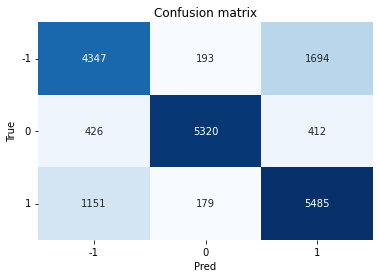

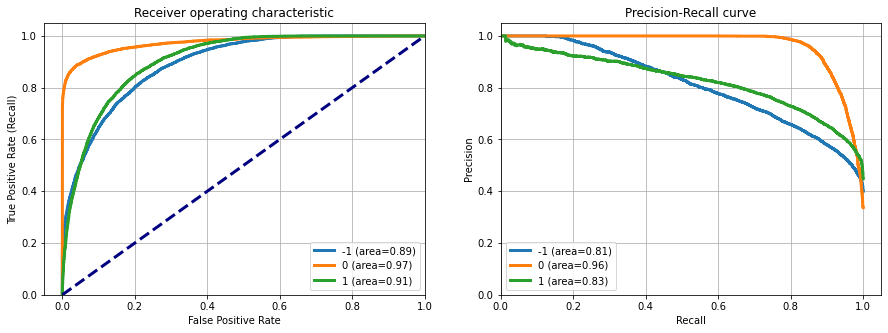

In [89]:
evaluate_multi_classif(y_val, predicted, predicted_prob)

In [230]:
#Create a pipeline to use an Untuned TfidfVectorizer() and MultinomialNB()
pipe_nb = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])
#Cross validate
# cv_nb = cross_validate(pipe_nb, X_train['processed_content'], y_train, return_train_score=True, \
#                     scoring=['accuracy', 'recall_micro'])
#See the results
# cv_nb

In [240]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, roc_auc='skip'):
    '''
    orginial function at : 
    (https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb)
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score
    
    Inputs:
        estimator: a fit sklearn-style model or pipeline
        X_tr: array or pandas dataframe
            training input variables
        X_te: array or pandas dataframe
            testing input variables
        y_tr: array or pandas series
            training output variable
        y_te: array or pandas series
            testing output variable
        roc_auc: str
            'skip': default, skips calculating roc_auc
            'dec': use decision_function to calculate roc_auc
            'proba': use predict_proba to calculate roc_auc
            
    '''
    # Grab predictions
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")    
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_te, y_te, values_format='.5g', cmap=plt.cm.Oranges)

In [263]:
param_grid = {
    "tfidf__max_features" : [10000],
    'nb__alpha': [1e-3]
}

In [264]:
grid = GridSearchCV(pipe_nb, param_grid, cv=3, return_train_score=True)

In [265]:
output = grid.fit(X_train["processed_content"], y_train)

In [266]:
output.best_params_

{'nb__alpha': 0.001, 'tfidf__max_features': 10000}

In [267]:
output.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=10000)),
                ('nb', MultinomialNB(alpha=0.001))])

In [283]:
output.best_estimator_.fit(X_train["processed_content"], y_train)
X_val =X_val["processed_content"].values

print(nb.score(X_train, y_train))
print(nb.score(X_val, y_val))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [282]:
predicted = output.best_estimator_.predict(X_val)
predicted_prob = output.best_estimator_.predict_proba(X_val)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

### Logistic Regression

In [272]:
lr= LogisticRegression()
lr.fit(X_train_tfidf_vec_df, y_train)

lr.fit(X_train_tfidf_vec_df, y_train)

X_val =X_val_tfidf_vec_df.values
predicted = lr.predict(X_val)
predicted_prob = lr.predict_proba(X_val)

print(lr.score(X_train_tfidf_vec_df, y_train))
print(lr.score(X_val_tfidf_vec_df, y_val))

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

0.9300081567484076
0.916332587077628


Accuracy: 0.92
Auc: 0.98
Detail:
              precision    recall  f1-score   support

          -1       0.87      0.88      0.88      6234
           0       0.99      0.98      0.99      6158
           1       0.89      0.89      0.89      6815

    accuracy                           0.92     19207
   macro avg       0.92      0.92      0.92     19207
weighted avg       0.92      0.92      0.92     19207



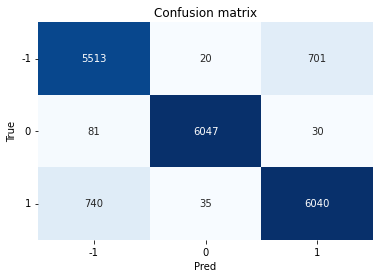

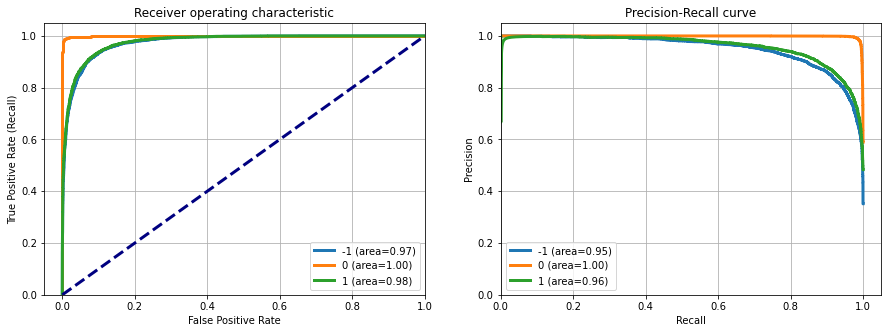

In [273]:
evaluate_multi_classif(y_val, predicted, predicted_prob)

### Logisitic Regression with PCA

In [274]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [276]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf_vec_df) #Use default count vectorizer
X_val_scaled = scaler.transform(X_val_tfidf_vec_df)

In [277]:
pca = PCA(n_components = .95, random_state=seed)
pca.fit(X_train_scaled)
pca.n_components_

1662

In [278]:
pipe_lr = Pipeline([('pca', pca), 
                    ('lr', LogisticRegression(random_state=seed, max_iter=100000))])
pipe_lr.fit(X_train_scaled, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.95, random_state=42)),
                ('lr', LogisticRegression(max_iter=100000, random_state=42))])

In [279]:
predicted = pipe_lr.predict(X_val_scaled)
predicted_prob = pipe_lr.predict_proba(X_val_scaled)

Accuracy: 0.91
Auc: 0.98
Detail:
              precision    recall  f1-score   support

          -1       0.86      0.87      0.86      6234
           0       0.98      0.98      0.98      6158
           1       0.88      0.88      0.88      6815

    accuracy                           0.91     19207
   macro avg       0.91      0.91      0.91     19207
weighted avg       0.91      0.91      0.91     19207



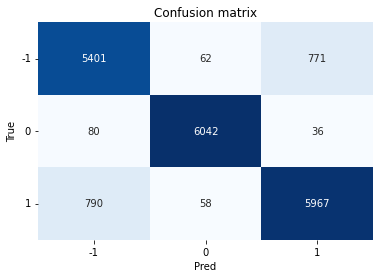

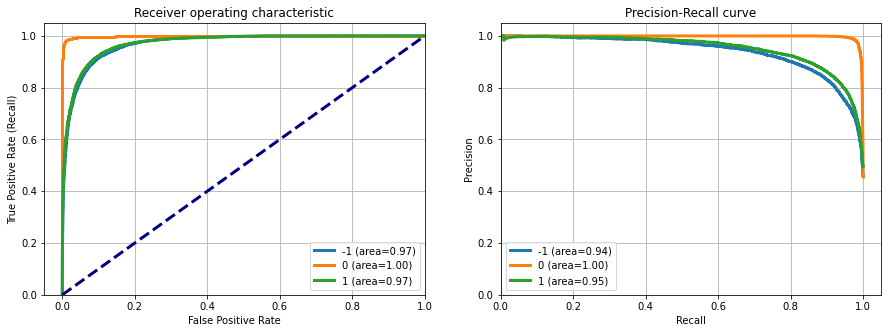

In [280]:
evaluate_multi_classif(y_val, predicted, predicted_prob)

In [281]:
print("PCA with n_components=0.95, default count vectorizer, and logistic regression")
print(pipe_lr.score(X_train_scaled, y_train))
print(pipe_lr.score(X_val_scaled, y_val))

PCA with n_components=0.95, default count vectorizer, and logistic regression
0.9337567900591798
0.9064403602853126


### Decision Trees

In [285]:
dt= DecisionTreeClassifier()

In [294]:
dt.fit(X_train_tfidf_vec_df, y_train)
y_pred = dt.predict(X_val_tfidf_vec_df)
print(classification_report(y_val, y_pred))
confusion_matrix(y_val, y_pred)

              precision    recall  f1-score   support

          -1       0.77      0.77      0.77      6234
           0       0.99      0.98      0.99      6158
           1       0.79      0.80      0.79      6815

    accuracy                           0.85     19207
   macro avg       0.85      0.85      0.85     19207
weighted avg       0.85      0.85      0.85     19207



array([[4811,   41, 1382],
       [  55, 6060,   43],
       [1346,   37, 5432]], dtype=int64)

In [ ]:
evaluate2(dt, X_train_tfidf_vec_df, y_train, X_val_tfidf_vec_df, y_val)

In [295]:
print(confusion_matrix(y_val, y_pred))

[[4811   41 1382]
 [  55 6060   43]
 [1346   37 5432]]


In [300]:
def evaluate2(model, X_tr, y_tr, X_te, y_te):
    print('Accuracy Score:')
    print(f'Train - {accuracy_score(y_tr, model.predict(X_tr))}')
    print(f'Test - {accuracy_score(y_te, model.predict(X_te))}')
    print('  ')
    print('Classification Report:')
    print(classification_report(y_te, model.predict(X_te)))
    print('Confusion matrix for test data')
    return plot_confusion_matrix(model, X_te, y_te, include_values=True, cmap=plt.cm.Blues)

In [301]:
dt_grid_params = {'max_depth':[1,5], 'min_samples_split':[2,10,100]}
dt_grid = GridSearchCV(dt, dt_grid_params)

dt_output = dt_grid.fit(X_train_tfidf_vec_df, y_train)
dt_output.best_params_

dt_best_model = dt_output.best_estimator_
cross_validate(dt_best_model, X_train_tfidf_vec_df, y_train, return_train_score=True)


KeyboardInterrupt: 

Accuracy Score:
Train - 0.8894153173322227
Test - 0.850210860623731
  
Classification Report:
              precision    recall  f1-score   support

          -1       0.74      0.85      0.79      6234
           0       0.99      0.98      0.99      6158
           1       0.85      0.73      0.78      6815

    accuracy                           0.85     19207
   macro avg       0.86      0.85      0.85     19207
weighted avg       0.86      0.85      0.85     19207

Confusion matrix for test data


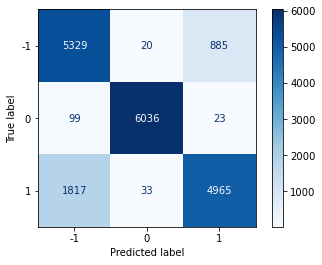

In [302]:
evaluate2(dt_best_model, X_train_tfidf_vec_df, y_train, X_val_tfidf_vec_df, y_val)

### Random Forests

In [308]:
rfc = RandomForestClassifier(random_state=42)

In [309]:
rfc.fit(X_train_tfidf_vec_df, y_train)

RandomForestClassifier(random_state=42)

Accuracy Score:
Train - 0.9999305808646153
Test - 0.8488051231321914
  
Classification Report:
              precision    recall  f1-score   support

          -1       0.77      0.77      0.77      6234
           0       0.99      0.98      0.99      6158
           1       0.79      0.80      0.79      6815

    accuracy                           0.85     19207
   macro avg       0.85      0.85      0.85     19207
weighted avg       0.85      0.85      0.85     19207

Confusion matrix for test data


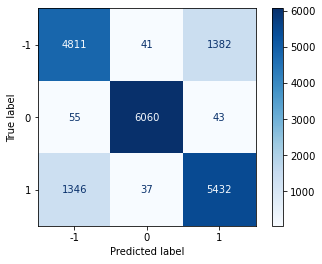

In [311]:
y_pred = rfc.predict(X_val_tfidf_vec_df)
evaluate2(dt, X_train_tfidf_vec_df, y_train, X_val_tfidf_vec_df, y_val)

In [313]:
rfc_grid_params = {'max_depth':[5,10,15], 'min_samples_split':[2,100,500]}
rfc_grid = GridSearchCV(rfc, rfc_grid_params)

rfc_output = rfc_grid.fit(X_train_tfidf_vec_df, y_train)
rfc_output.best_params_
rfc_best_model = rfc_output.best_estimator_

Accuracy Score:
Train - 0.9220423109630169
Test - 0.8720258239183631
  
Classification Report:
              precision    recall  f1-score   support

          -1       0.85      0.75      0.79      6234
           0       1.00      0.99      0.99      6158
           1       0.79      0.88      0.83      6815

    accuracy                           0.87     19207
   macro avg       0.88      0.87      0.87     19207
weighted avg       0.88      0.87      0.87     19207

Confusion matrix for test data


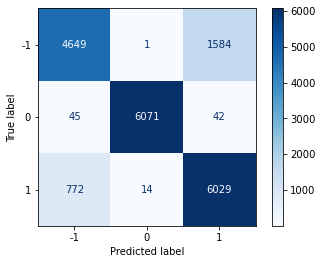

In [315]:
cross_validate(rfc_best_model, X_train_tfidf_vec_df, y_train, return_train_score=True)
evaluate2(rfc_best_model, X_train_tfidf_vec_df, y_train, X_val_tfidf_vec_df, y_val)

### Support Vector Machines

### Word2Vec

### Nueral Network

### BERT